In [ ]:
!pip install tqdm
!pip install scikit-learn
!pip install seaborn
!pip install matplotlib

In [189]:
import numpy as np
import seaborn as sns
import torch
import h5py # pour gérer les formats de données utilisés ici
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
device = "cuda" if torch.cuda.is_available() else "cpu"


# TP3: Reconnaissance de signaux de communication par apprentissage profond

<div class=consignes> Listez les noms des étudiants (2 au maximum) ayant participé à ce notebook dans la cellule suivante (prénom, nom).<br/>
Au moment du rendu, le notebook doit être nommé nom1_nom2_dlts_tp3.ipynb

2 séances de TP sur ce sujet : le 6 novembre (1h00), le 13 novembre (3h).
Le cours du 19 novembre sera partagé en 3 : cours sur la séparation de sources audio / présentation des mini projets et organisation des soutenances / fin de ce TP.<br>
Deadline pour le rendu du TP: 26 novembre 2024, 13h59, par mail à deepetsignal.mva@gmail.com <br>

Pour installer les paquets nécessaires à la réalisation de ce TP vous pouvez utiliser dans le notebook
    
```
!pip install \< nom_du_paquet \>
```
merci de regrouper toutes les installations dans la première cellule du notebook.
Essayez de faire en sorte que votre notebook puisse se lire comme un compte rendu, évitez de laisser du code mort et prennez le temps de commenter vos observations et résultats.

Noah KWA MOUTOME

Quentin MOAYEDPOUR

## Problématique

On cherche à identifier un type d'émetteur de communication à partir de l'observation d'un signal provenant de l'émetteur
de 2048 échantillons IQ (In Phase / Quadrature) ie le signal prend des valeurs complexes. On représente la partie
réelle et la partie imaginaire du signal par deux canaux réel d'un signal multivarié.

L'émetteur peut provenir de 6 catégories différentes.
Les paramètres différenciant les différentes catégories sont
- le type de modulation
- la présence ou non de séquences pilotes et le cas échéant la structure de trame pilotes / données
- le débit de la transmission

Les signaux se propagent en champs libre et sont enregistrés par une antenne. Le signal reçu est transposé en bande de base c'est à dire que si le signal est transmis autour d'une fréquence centrale f0, une première étape de traitement du signal à la réception recentre le signal autour de la fréquence 0.


Les différents signaux observés dans ce TP sont entachés de différentes erreurs caractéristiques de la propagation
électromagnétique comme :
- modification aléatoire de la phase du signal lors de la transmission
- imperfection de la transposition en bande de base qui laisse le signal transposé à une fréquence df0 << f0
- présence d'interférence entre les symboles transmis (dûes par exemple à plusieurs chemins de propagation)
- présence d'un bruit blanc additif gaussien

Le niveau du bruit relativement à celui du signal utile est décrit par le SNR (Signal to Noise Ratio) et exprimé en dB. On suppose que le SNR est connu lors de l'acquisition d'un signal. Lors de ce TP nous rencontrerons 4 niveaux de SNR: 30 dB (facile), 20 dB, 10 dB et 0 dB (en espérant qu'on puisse faire quelque chose de ces données).
Un de nos objectifs sera de qualifier la performance des algorithmes mis en place en fonction du SNR.

Les objectifs de ce TP sont:

1. Définir une ou plusieurs architectures de réseaux de neurones profonds et les implémenter en PyTorch
2. Entrainer ces architectures, la fonction de perte employée pourra être la log vraisemblance négative: https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html.
3. Qualifier les performances de votre réseau de neurones sur l'ensemble de test via:
   - Le calcul de l'accuracy implémentée par exemple dans le package TorchMetrics (https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html)
   - La réalisation d'un graphique accuracy vs SNR
   - La réalisation des matrices de confusion entre les différentes classes pour les différents SNR (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)
4. Rapporter les performances de vos architectures à leur complexité, la complexité d'un réseau de neurones étant ici résumé au nombre de paramètres libres qu'il fait intervenir

Durant l'entraînement on observera l'évolution de la fonction de perte et de l'accuracy sur l'ensemble d'entraînement et sur l'ensemble de validation.


Les 4 premières parties sont un échauffement sur lequel vous pouvez passer vite si vous êtes à l'aise avec le sujet.
Le gros du travail est dans la partie 5 "Entraînemenent d'un réseau de neurones".

Surtout privilégiez dans un premier temps la simplicité quitte à complexifier votre approche ensuite pour doper ses performances. Ne restez pas bloqué sur des réseaux qui "mettent trop de temps à apprendre"

## Chargement des données en numpy

Le TP est composé de trois jeux de données :
- train.hdf5 destiné à nourrir l'entrainement de réseaux de neurones
- test.hdf5 destiné à évaluer les algorithmes après entrainement
- samples.hdf5 qui est beaucoup plus petit que train.hdf5 et destiné à servir de modèle de données dans une phase de prototypage
des algorithmes et de la pipeline d'entrainement

Les trois jeux de données sont au format hdf5 qui peut être manipulé via l'API Python h5py https://docs.h5py.org/en/stable/quick.html.
Un fichier hdf5 est consitué d'une arborescence de datasets et de groups. Un dataset hdf5 représente un tenseur n dimensionnel. Un dataset se convertit très facilement en numpy array.

Par exemple vous pouvez charger les données samples selon la cellule suivante:

In [2]:
data_path = 'samples.hdf5'
data = h5py.File(data_path , 'r')

signals = np.array(data['signaux'])
snr =  np.array(data['snr'])
labels_id = np.array(data['labels'])

data.close()

Vous pouvez récupérer le nom de la correspondance entre un label et le nom du standard d'émetteur correspondant via:

In [3]:
def get_labels(open_h5_file):
    return {
        open_h5_file['label_name'].attrs[k] : k
        for k in open_h5_file['label_name'].attrs.keys()
    }

### Visualisation des données

Commencez par étudier les données:

    - observez leur taille
    - la distribution des différentes classes et des différents SNR dans l'ensemble d'entrainement
    - visualisez quelques signaux bien choisis selon une ou des représentations que vous choisirez

Remarque : dans ce TP il n'y a pas beaucoup à gagner à faire du feature engineering

200
Counter({np.int8(1): 36, np.int8(2): 35, np.int8(4): 34, np.int8(0): 34, np.int8(3): 32, np.int8(5): 29})
Counter({np.int16(10): 80, np.int16(30): 60, np.int16(20): 40, np.int16(0): 20})
2


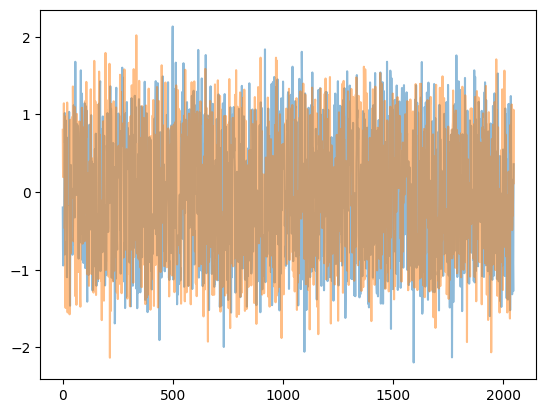

In [4]:
print(len(signals))
print(Counter(labels_id))
print(Counter(snr))

print(labels_id[0])
plt.plot(signals[0], alpha=0.5)
plt.show()

In [5]:
def stats_by_class(snr, labels_id):
    classes = np.unique(labels_id)
    for c in classes:
        class_snr = snr[labels_id == c]
        mean_snr = np.mean(class_snr)
        max_snr = np.max(class_snr)
        min_snr = np.min(class_snr)
        std_snr = np.std(class_snr)
        n_data = len(class_snr)
        print(f"Label {c} - Moyenne: {mean_snr:.2f}, Max: {max_snr:.2f}, Min: {min_snr:.2f}, Std: {std_snr:.2f}, N data: {n_data:.2f}")
stats_by_class(snr, labels_id)
# TODO COMMENTER

Label 0 - Moyenne: 17.06, Max: 30.00, Min: 0.00, Std: 11.25, N data: 34.00
Label 1 - Moyenne: 17.50, Max: 30.00, Min: 0.00, Std: 10.10, N data: 36.00
Label 2 - Moyenne: 13.71, Max: 30.00, Min: 0.00, Std: 8.97, N data: 35.00
Label 3 - Moyenne: 18.44, Max: 30.00, Min: 0.00, Std: 9.39, N data: 32.00
Label 4 - Moyenne: 17.65, Max: 30.00, Min: 0.00, Std: 9.41, N data: 34.00
Label 5 - Moyenne: 17.93, Max: 30.00, Min: 0.00, Std: 10.30, N data: 29.00


/tmp/ipykernel_3594/2957209613.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right", fontsize='small')


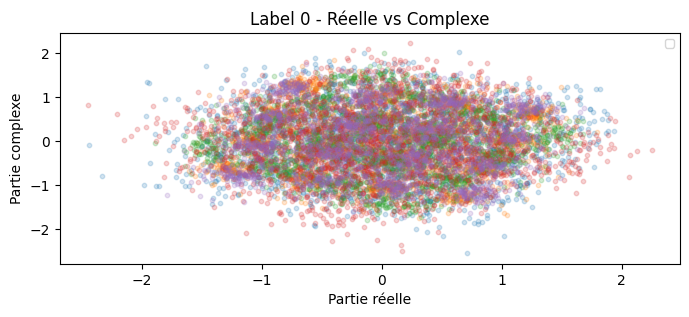

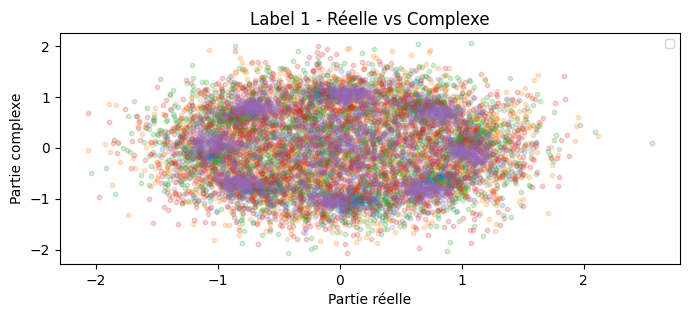

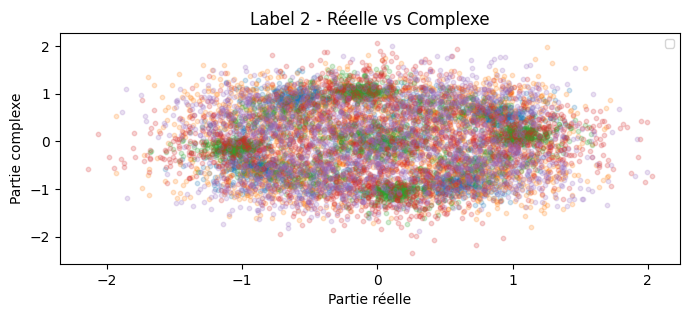

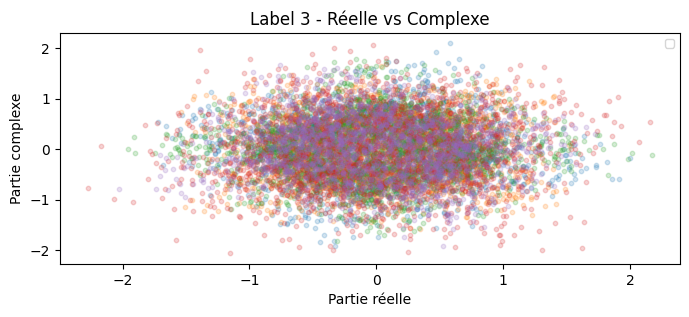

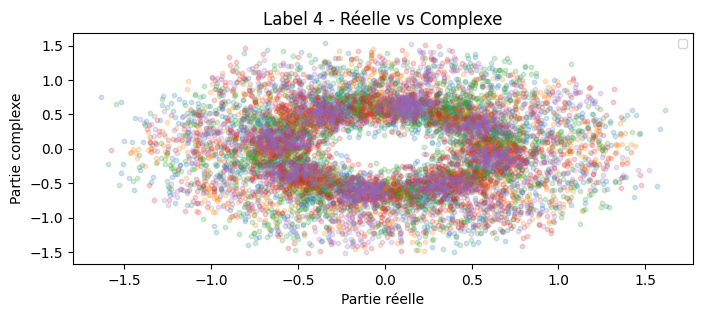

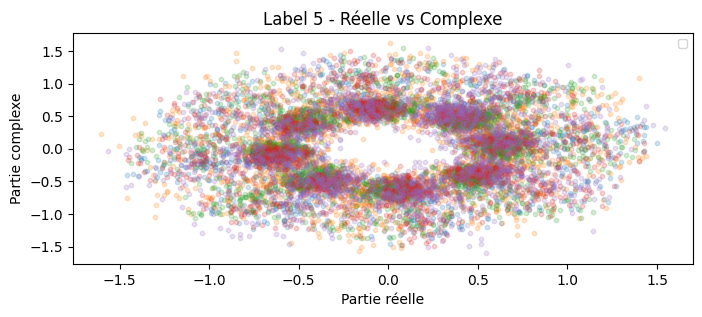

In [5]:
def plot_real_vs_complex_by_class(signals, labels_id, k=2):
    classes = np.unique(labels_id)
    for c in classes:
        class_indices = np.where(labels_id == c)[0]
        selected_indices = np.random.choice(class_indices, size=min(k, len(class_indices)), replace=False)
        plt.figure(figsize=(8, 3))
        for i in selected_indices:
            dim1 = signals[i, :, 0]
            dim2 = signals[i, :, 1]
            plt.scatter(dim1, dim2, s=10, alpha=0.2)
        plt.xlabel('Partie réelle')
        plt.ylabel('Partie complexe')
        plt.title(f'Label {c} - Réelle vs Complexe')
        plt.legend(loc="upper right", fontsize='small')
        plt.show()

plot_real_vs_complex_by_class(signals, labels_id, k=5)

Comme on peut le voir sur ces graphiques, il semble y avoir certaines structures dans les données. Cependant, celles-ci sont trop complexes pour pouvoir dégager un modèle simple basé sur les relations entre les variables.

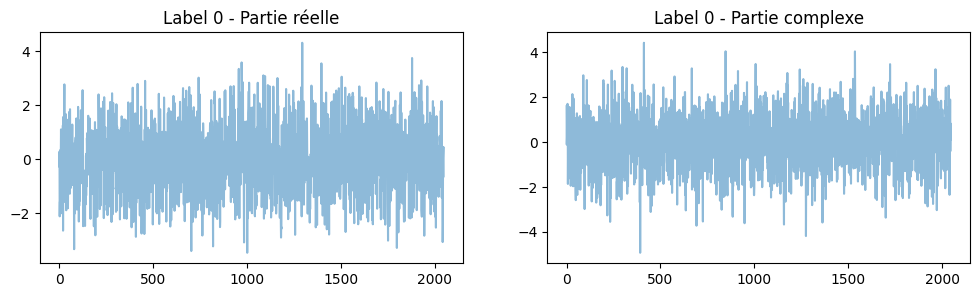

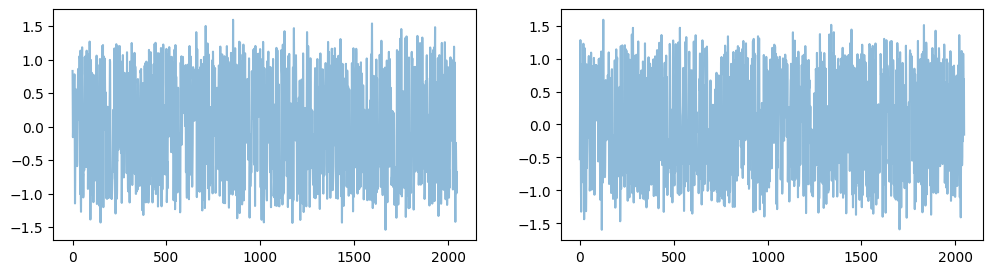

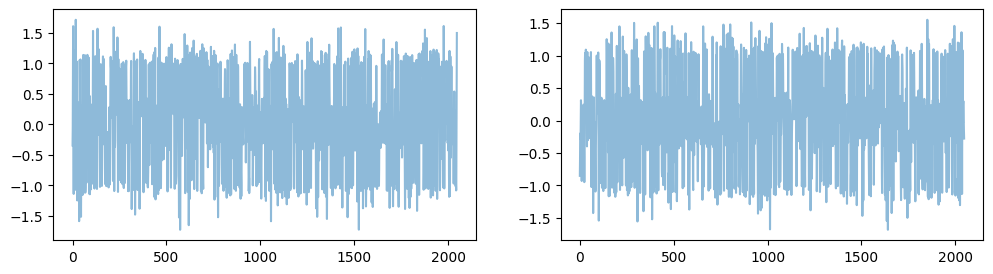

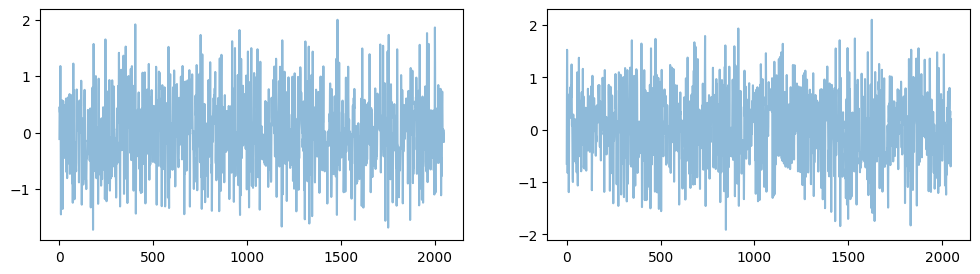

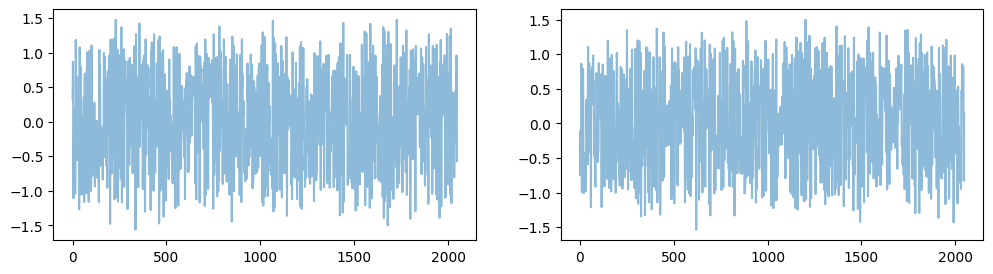

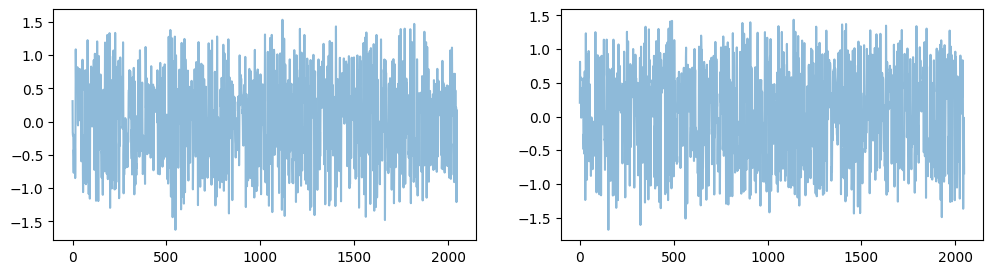

In [6]:
def plot_signals_by_class(signals, labels_id, k=8):
    classes = np.unique(labels_id)
    j=0
    for c in classes:
        class_indices = np.where(labels_id == c)[0]
        selected_indices = np.random.choice(class_indices, size=min(k, len(class_indices)), replace=False)
        fig, axes = plt.subplots(1, 2, figsize=(12, 3))
        for i in selected_indices:
            axes[0].plot(signals[i, :, 0], alpha=0.5)
            axes[1].plot(signals[i, :, 1], alpha=0.5)
        if j ==0:
            axes[0].set_title(f'Label {c} - Partie réelle')
            axes[1].set_title(f'Label {c} - Partie complexe')
            j+=1
        plt.show()

plot_signals_by_class(signals, labels_id, k=1)

Cette représentation est très peu informative

/tmp/ipykernel_3594/2165159127.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


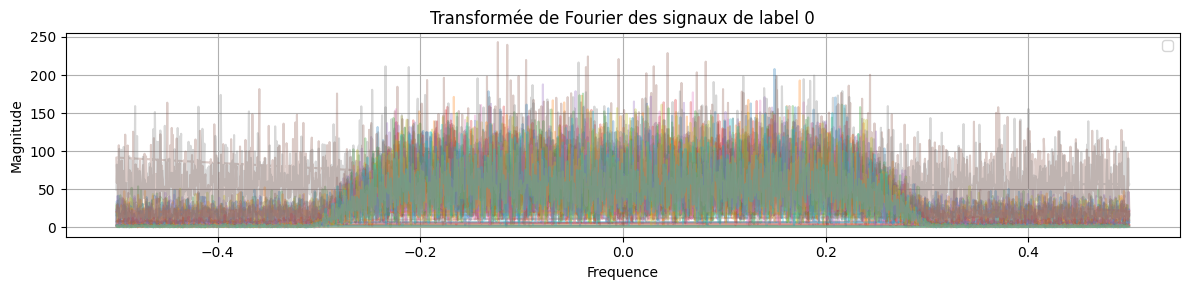

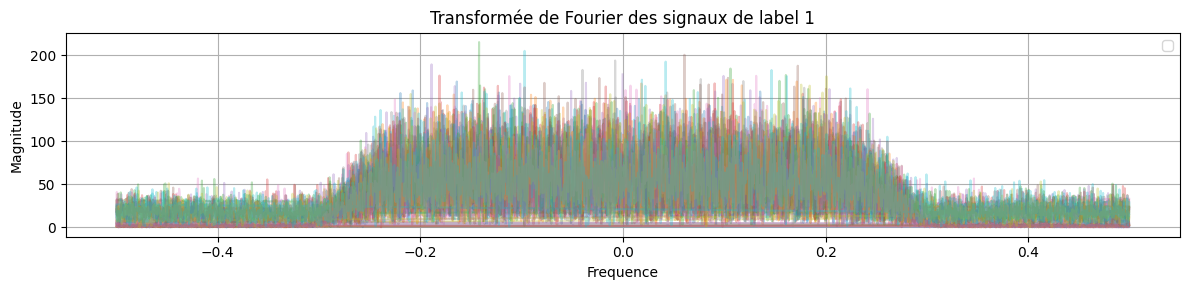

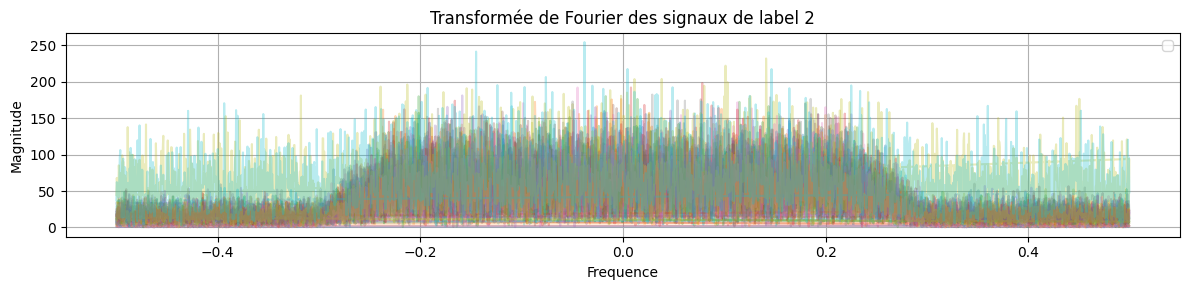

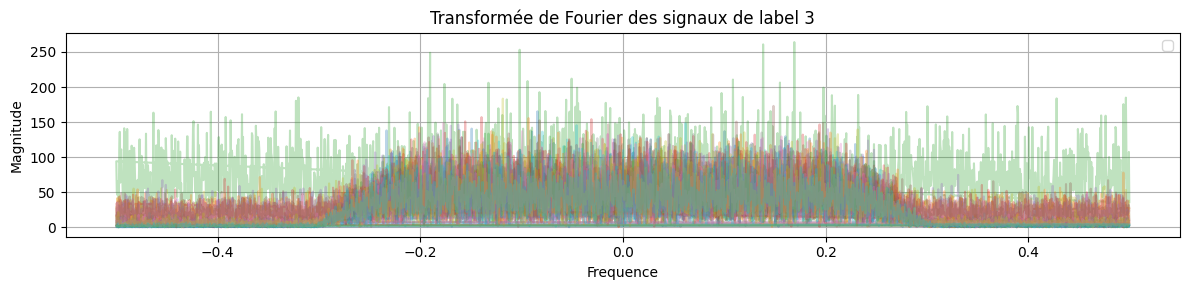

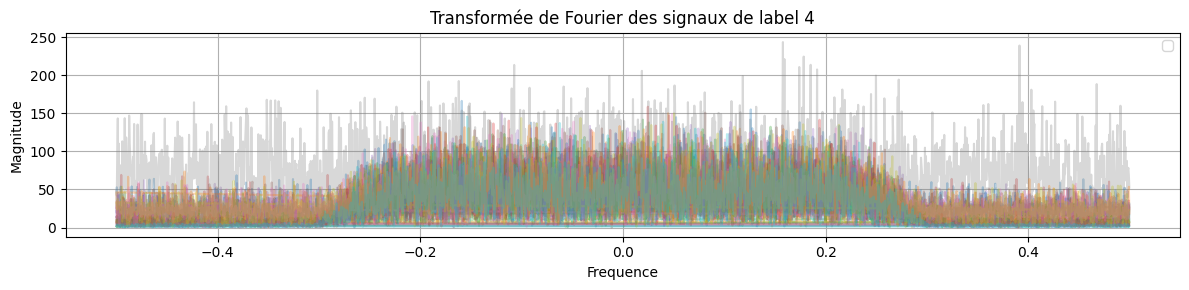

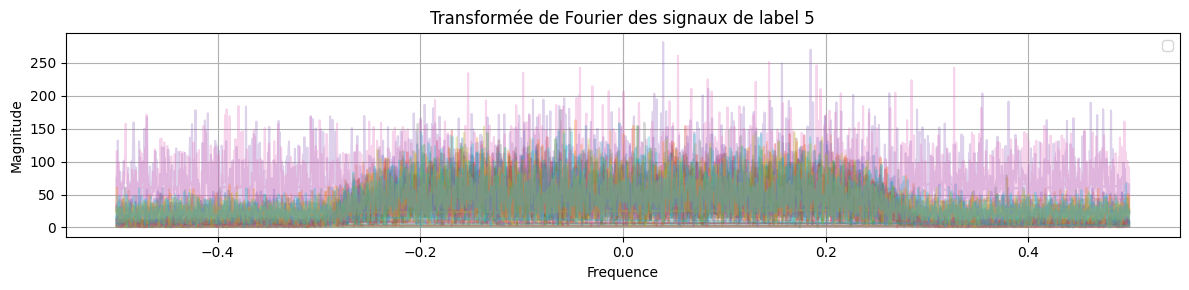

In [7]:
def plot_fourier_signals(signals, labels_id, k=1):
    classes = np.unique(labels_id)
    
    for label in classes:
        class_indices = np.where(labels_id == label)[0]
        selected_indices = np.random.choice(class_indices, k, replace=False)
        
        plt.figure(figsize=(12, 3))
        
        for i, idx in enumerate(selected_indices):
            signal_real = signals[idx, :, 0]
            signal_imag = signals[idx, :, 1]
            signal_complex = signal_real + 1j * signal_imag
            fft_signal = np.fft.fft(signal_complex)
            freqs = np.fft.fftfreq(len(signal_real), d=1)
            magnitude = np.abs(fft_signal)
            plt.plot(freqs, magnitude, alpha=0.3)
        
        plt.title(f"Transformée de Fourier des signaux de label {label}")
        plt.xlabel("Frequence")
        plt.ylabel("Magnitude")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

plot_fourier_signals(signals, labels_id, k=20)

Il semble en effet y avoir des différences entre les classes qui peuvent se remarquer à l'aide de la transformée de Fourier, mais celles ci ont l'ait trop complexe pour en déduire un estimateur naïf.

In [186]:
print(signals[1].shape)

(2048, 2)


In [5]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, path_to_data):
        data = h5py.File(path_to_data , 'r')
        self.signals = np.array(data['signaux']).transpose(0,2,1)
        self.snr =  np.array(data['snr'])
        self.labels_id = np.array(data['labels'])
        self.labels_names = get_labels(data)
        data.close()

    def __len__(self):
        return self.signals.shape[0]

    def __getitem__(self, i):
        return (self.signals[i], self.snr[i], self.labels_id[i])

Instanciez un objet dataset et testez le sur les données samples
```python
dataset = MyDataset(...)
```

In [6]:
data_path = 'samples.hdf5'
dataset = MyDataset(data_path)

sample_signal, _, sample_label = dataset[0]
print("Signal shape:", sample_signal.shape)
print("Signal type:", type(sample_signal))
print("Label:", sample_label)
print("Label type:", type(sample_label))

Signal shape: (2, 2048)
Signal type: <class 'numpy.ndarray'>
Label: 2
Label type: <class 'numpy.int8'>


Pytorch propose une classe Dataloader qui permet d'échantillonner des batchs de taille fixe à partir d'un dataset.
La cellule suivante donne un exemple d'utilisation

In [7]:
dataloader = DataLoader(dataset,
                        batch_size=10,
                        shuffle=True
                       )

Testez le dataloader pour différentes valeurs de batch_size

In [8]:
for sig, _, lab in dataloader:
    print(sig.shape, lab.shape)
    break

torch.Size([10, 2, 2048]) torch.Size([10])


## Mise en place d'un réseau "dumb" pour tester la pipeline d'entrainement

Définissez un premier modèle Pytorch qui prend en entrée un batch de données (tenseur de dimensions [B , C, T] avec B la taille du batch, C le nombre de canaux des signaux et T le nombre d'échantillons dans les signaux) et renvoie un batch de vecteur de probabilités (ou de log probabilités si vous préférez) (tenseur de dimensions [B,N] où N est le nombre de classe à identifier).

Ce modèle doit comporter moins de 10000 paramètres libres.

Ce Modèle doit être très simple, il doit être rapide à exécuter, il servira à tester et éventuellement débugger la pipeline d'entrainement que vous mettrez en place un peu plus loin. Un template d'implémentation d'une classe Model se trouve dans les diapositives du cours.

Instanciez votre modèle et testez la consistence de ses entrées / sorties vis à vis des données étudiées (test purement fonctionnel, pas besoin de chercher à réaliser un entraînement à ce point).

In [ ]:
class DumbModel(nn.Module): # nn.Module permet d'hériter de pleins de fonctionnalités pratique, par ex si on appel le modèle
                            # avec model(sample) ça fait model.forward(sample)
    def __init__(self, input_size=2048, num_classes=6, out_channels=8, kernel_size=3, stride=5):
        super(DumbModel, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=out_channels, kernel_size=self.kernel_size, stride=self.stride)
        self.pool = nn.MaxPool1d(kernel_size=2)
        # calcul "à la main" de la dim_0 de sortie (T_out)
        conv_output_size = ((input_size - self.kernel_size) // self.stride) // 2  + (stride % 2) # On a pas utiliser l'option padding='same' sinon dim entrée = dim sortie//2 (car on utilise un maxpool)
        self.fc1 = nn.Linear(out_channels * conv_output_size, num_classes)
        self.out = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return self.out(x)


In [10]:
B = 8     # batch size
C = 2     # dimension de la série
T = 2048  # taille de la série temporelle
n_classes = 6 # Nombre de classes

model = DumbModel(T, n_classes, out_channels=4, kernel_size=20, stride=10)

input_data = torch.randn(B, C, T)  # (8, 2, 2048)
output = model(input_data)

print("Forme de l'entrée :", input_data.shape)
print("Forme de la sortie :", output.shape)
print(output)

Forme de l'entrée : torch.Size([8, 2, 2048])
Forme de la sortie : torch.Size([8, 6])
tensor([[-1.9720, -2.1041, -1.7908, -1.8324, -1.5757, -1.5840],
        [-2.2382, -1.6976, -1.7740, -1.7299, -1.7592, -1.6550],
        [-1.8511, -2.2749, -1.9270, -1.4451, -1.9140, -1.5543],
        [-1.9942, -2.0603, -1.6324, -1.9787, -1.9675, -1.3358],
        [-1.1738, -2.6466, -2.0314, -1.8662, -1.8005, -1.7788],
        [-2.1576, -1.7312, -1.6786, -1.8366, -2.0083, -1.4822],
        [-1.6020, -2.5690, -1.7175, -1.8486, -2.0428, -1.3655],
        [-2.0476, -1.7443, -1.7240, -1.8699, -1.8701, -1.5626]],
       grad_fn=<LogSoftmaxBackward0>)


Estimez par un calcul "théorique" le nombre de paramètres du modèle que vous avez défini et vérifié que le modèle a bien ce nombre de paramètres en pratique par exemple en utilisant la fonction suivante :

Nombre de paramètres:
On a une couche de convolution qui a un nombre de paramètres:


$\text{kernel}* \text{dim in(=2)} * \text{dim out (=4)} + \text{biais (=dim out)}$

Et une couche linéaire qui a pour nombre de paramètres:

$\text{dim out} * \text{len output conv} * \text{n classes} + \text{biais (= n classes)}$

Où ``len output conv`` est la taille de sortie après le produit de convolution. Généralement on peut conserver la même dimension d'entrée (ici 2048) avec un stride de 1 et avec les paramètres du padding mais ici on ne l'a pas fait car on souhaitait justement réduire la dimension.

In [11]:
input_size = 2048
n_classes = 6
kernel_size = 20
out_channels = 4 # = dim out
dim_in = 2
stride = 10
n_params_linear = out_channels* (((input_size - kernel_size) // stride) // 2  + (stride % 2)) *n_classes+ n_classes
n_params_conv = kernel_size* dim_in * out_channels + out_channels
print(n_params_linear+n_params_conv)

2594


In [12]:
def count_n_param(model):
    return sum([p.numel() for p in model.parameters()])

print(count_n_param(model))

2594


Mettez en place votre pipeline et testez là sur votre modèle dumb. Faites en sorte que votre façon de logger les loss et les métriques vous permette de visualiser l'évolution de ces différents indicateurs sur l'ensemble d'entrainement et de validation au fil des epochs.

In [13]:
train_dataset = MyDataset('train.hdf5')
dataloader_train = DataLoader(train_dataset,
                        batch_size=256,
                        shuffle=True
                       )

valid_dataset = MyDataset('validation.hdf5')
dataloader_valid = DataLoader(valid_dataset,
                                batch_size=128,
                                shuffle=False
                                 )

test_dataset = MyDataset('test.hdf5')
dataloader_test = DataLoader(test_dataset,
                                batch_size=32,
                                shuffle=False
                                 )

On crée une classe MyTrainer qui permettra de faire toute les opérations nécessaires sur nos modèles

In [ ]:
class MyTrainer(object):
    def __init__(self, model, verbose=True, device="cpu"):
        self.model = model
        self.verbose = verbose  # Les modèles sont généralement long à entrainer
        # donc généralement une barre de progression avec tqdm est la bienvenue
        # et généralement, verbose permet de dire si on veut afficher certains logs du modèle
        # par ex si j'entraine le modèle depuis un terminal, je serai moins intéressé par l'affichage de
        # certains logs
        self.device = device # On spécifie le device sur lequel on veut entraine le modèle
        self.train_loss = []
        self.accuracy_test = []
        self.test_loss = []

    
    def fit(self, n_epochs=100, path_to_data=False, dataloader=None, batch_size=32, lr=1e-5, valid_loader=None,
            critic_test=5, criterion=nn.NLLLoss(), model_path="model.pth", patience=5):
        """ fit le modèle
        n_epochs (int): nombre d'epoch du modèle
        path_to_data (str): chemin vers le jeux de données si le dataloader n'est pas encore créer
        dataloader: dataloader de train
        batch_size (int): si dataloader pas encore défini, taille du batch_size
        lr (float): learning rate
        valid_loader: dataloader de validation
        critic_test (int): fréquence de test du modèle pendant l'entraînement, le modèle test tout les critic_test epochs
        criterion: loss
        model_math (str): chemin vers le modèle
        patience (int): après combien de test sans amélioration on décide de stopper l'entraînement
        Note: pour que le trainer soit plus "complet", on peut rajouter un paramètre optimizer et prendre en entrée
        du trainer l'optimizer aussi
        """
        # fit permet d'entraîner le modèle en prenant en entrée les données
        # path_to_data est optionnel si on a deja gérer le dataloader

        self.critic_test = critic_test
        if not path_to_data and dataloader is None:
            raise ValueError("Please insert a dataloader or a path to the dataset")
        if dataloader is None:
            dataloader = DataLoader(MyDataset(path_to_data), shuffle=True, batch_size=batch_size)
        
        self.model.to(self.device)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr) # On rattache l'optimiseur aux poids du modèles
        # Ici j'ai sélectionner Adam car c'est généralement le meilleur
        initial_loss = 0
        test_loss = 0
        count_patience = 0

        with tqdm(total=n_epochs, desc=f"Epoch 0/{n_epochs} - Train Loss: {initial_loss:.4f} - Test Loss: {test_loss:.4f}", leave=True) as epoch_bar:
            for epoch in range(n_epochs):
                epoch_loss = 0  # c'est la loss de l'epoch qu'on va afficher et nous permettre de décider quand s'arreter
                self.model.train()          
                for signals, _, labels in dataloader:
                    signals, labels = signals.to(self.device), labels.to(self.device).long()

                    optimizer.zero_grad() # L'optimiseur calcul les gradient associés à chaque paramètres
                    # a chaque itération on les remets à 0

                    outputs = self.model(signals)
                    loss = criterion(outputs, labels)
                    loss.backward() # calcul de la back propagation

                    optimizer.step() # ajustement des poids du modèle
                    epoch_loss += loss.item() # On ajoute à la loss
                
                avg_loss = epoch_loss/len(dataloader)
                epoch_bar.set_description(f"Epoch {epoch + 1}/{n_epochs} - Train Loss: {avg_loss:.4f} - Test Loss: {test_loss:.4f}")
                epoch_bar.update(1)
                self.train_loss.append(avg_loss)

                if valid_loader is not None and epoch%critic_test==1:

                    test_labels, test_preds, t_loss = self._test(valid_loader, training=True, criterion=criterion)
                    test_loss = t_loss/len(valid_loader)

                    if test_loss< min(self.test_loss) if self.test_loss else np.inf:
                        self._save_model(model_path, verbose=False)
                        count_patience = 0 
                    count_patience+=1
                    self.test_loss.append(test_loss)
                    self.accuracy_test.append(accuracy_score(test_labels, test_preds))
                if count_patience > patience:
                    break  # Si au bout de "count_patience" test on n'a pas dépassé la loss de test la plus basse, on arrete l'entrainement
                    # Cependant, il faut parfois se méfier de cette méthode car on peut tendre à overfitter sur l'ensemble de validation
                    # Généralement, on favorise les modèles qui ont des performances similaires sur l'ensemble de validation et d'entraînement
        
        self._load_model(model_path, return_model=False, verbose=False)


    def _test(self, dataloader, training=False, criterion=nn.NLLLoss(), by_snr=False):
        """test le modèle
        dataloader : dataloader des données sur lequel on souhaite tester le modèle
        training (bool): permet de retourner certains paramètres spécifiques lorsque on entraîne le modèle
        criterion : loss
        """
        self.model.eval()

        if by_snr:
            all_labels = {f"{i*10}": [] for i in range(4)}
            all_preds = {f"{i*10}": [] for i in range(4)}
        else:
            all_labels = []
            all_preds = [] 
        test_loss = 0           
        with torch.no_grad():  # Permet de ne pas calculer les gradient pendant la phase de test
            for signals, snr, labels in dataloader if training else tqdm(dataloader):
                signals, labels = signals.to(self.device), labels.to(self.device).long()

                outputs = self.model(signals)
                _, preds = torch.max(outputs, dim=1)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                if by_snr:
                    for s, label in zip(snr, labels):
                        all_labels[str(int(s.cpu().numpy()))].append(int(label.cpu().numpy()))
                    for s, pred in zip(snr, preds):
                        all_preds[str(int(s.cpu().numpy()))].append(int(pred.cpu().numpy()))
                    continue
                else:
                    all_labels.extend(labels.cpu().numpy())
                    all_preds.extend(preds.cpu().numpy())

        if by_snr:
            return (all_labels, all_preds)

        report = classification_report(all_labels, all_preds, zero_division=0)
        
        if training:
            return (all_labels, all_preds, test_loss)
        
        else:
            print(report)
            return (all_labels, all_preds)

    def plot_loss(self):
        """affiche graphiquement la fonction de perte moyenne pendant l'entraînement et les étapes de validations
        """
        epochs = range(1, len(self.train_loss) + 1)
        test_epochs = range(self.critic_test, self.critic_test * len(self.test_loss) + 1, self.critic_test) 

        plt.figure(figsize=(10, 6))

        plt.plot(epochs, self.train_loss, label='Train Loss', color='blue')

        plt.plot(test_epochs, self.test_loss, label='Test Loss', color='red')

        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Train and Test Loss per Epoch')
        plt.legend()
        plt.show()
    
    def full_proc(self, train_dataloader, valid_dataloader, test_dataloader, n_epochs=100, lr=1e-5,
                  critic_test=5, criterion=nn.NLLLoss(), model_path="model.pth"):
        """Renvoie la procédure entière du modèle: entraîner le modèle, sélectionner le meilleur, afficher la
        fonction de perte moyenne pendant l'entraînement et le tester
        train_dataloader: dataloader d'entraînement
        valid_dataloader: dataloader de validation
        test_dataloader: dataloder de test
        n_epochs (int): nombre d'epochs
        lr (float): learning rate
        critic_test (int): fréquence de test du modèle sur le dataset de validation
        criterion : loss
        model_path (str): chemin vers le modèle pour sauvegarder
        """
        self.fit(dataloader=train_dataloader, valid_loader=valid_dataloader,
                 n_epochs=n_epochs, lr=lr, critic_test=critic_test, criterion=criterion,
                 model_path=model_path)
        
        self.plot_loss()

        lab, preds = self._test(test_dataloader)

        return accuracy_score(lab, preds)

    def _save_model(self, path="model.pth", verbose=True):

        torch.save(self.model.state_dict(), path)
        if verbose:
            print(f"Model saved @ {path}")
    
    def _load_model(self, path="model.pth", verbose=True, return_model=False):

        self.model.load_state_dict(torch.load(path))
        if verbose:
            print("Model successfully loaded")

        if return_model:
            return self.model
        

Notre trainer permet de faire les opérations suivante lorsque on utilise ``.fit()``:

* Entrainer le modèle sur dataloader
* tester le modèle sur l'ensemble de validation toute les ``critic_test`` epochs
* Si le modèle n'a pas d'amélioration sur l'ensemble de validation pendant ``patience`` tests, on arrête l'entraînement
* On charge ensuite le modèle qui a eu les meilleures performances sur l'ensemble de validation

Ensuite, la fonction ``.plot_loss()`` permet d'afficher la loss moyenne pendant l'entrainement en fonction de l'epoch pour l'ensemble de train et de validation

Enfin, la fonction ._test() permet de tester le modèle sur un ensemble particulier

On résume donc toute ces étapes dans la fonction ``.full_proc()`` (ie full procedure) qui entraîne le modèle, sélectionne l'entraînement au meilleur epoch et le test sur l'ensemble de test et renvoie l'accuracy sur l'ensemble de test.

In [ ]:
model = DumbModel() 

trainer = MyTrainer(model, device=device)

trainer.fit(dataloader=dataloader_train, valid_loader=dataloader_valid, n_epochs=300, critic_test=5, lr=1e-4)

Epoch 92/300 - Train Loss: 1.0496 - Test Loss: 1.2470:  31%|███       | 92/300 [01:14<02:47,  1.24it/s]
/tmp/ipykernel_1983/645861320.py:183: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimen

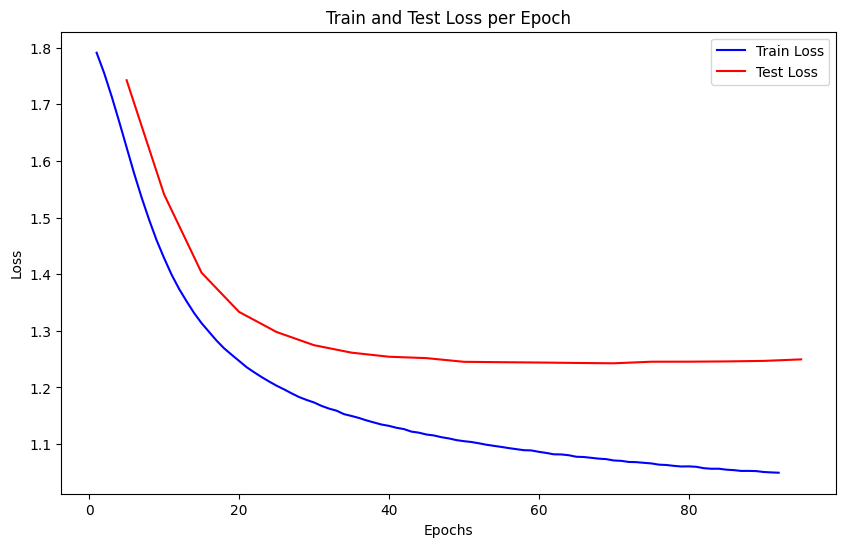

In [16]:
trainer.plot_loss()

In [17]:
_ = trainer._test(dataloader_test)

100%|██████████| 313/313 [00:00<00:00, 997.25it/s] 

              precision    recall  f1-score   support

           0       0.36      0.39      0.38      1697
           1       0.34      0.34      0.34      1650
           2       0.33      0.30      0.31      1653
           3       0.36      0.34      0.35      1653
           4       0.32      0.37      0.34      1684
           5       0.33      0.31      0.32      1663

    accuracy                           0.34     10000
   macro avg       0.34      0.34      0.34     10000
weighted avg       0.34      0.34      0.34     10000



Vérifiez que vous avez bien enregistré votre modèle en fin d'entrainement. Chargez le avec la fonction
```python
modele = torch.load(...)
```
et vérifiez que vous pouvez l'utiliser sur des données du problème.

In [ ]:
# Tout est "automatisé" dans la fonction, lors de l'entrainement, sauvegarde le meilleur modele et le charge

## Entraînement de réseaux de neurones

Dans cette partie vous définissez une ou plusieurs architecture de réseaux de neurones profonds et vous les réglez sur les données d'entrainement.
Vous pouvez notamment utiliser des réseaux à base de convolutions et/ou de couches réurrentes. Vous pouvez vous inspirer de ce qui a été dit en cours sur la reconnaissance vocale.

Dans un deuxième temps (facultatif), si vous le souhaitez vous pouvez mettre en place des stratégies d'augmentation de données pour améliorer vos résultats. Pour mettre l'augmentation de données en pratique pouvez vous renseigner sur l'argument collate_fn du dataloader standard de Pytorch.

Maintenant afin de pouvoir comparer les modèles, on crée un dictionnaire qui va stocker tout les meilleurs scores de chaque modèle.

In [18]:
dic_results = {}

Epoch 97/300 - Train Loss: 1.0650 - Test Loss: 1.2745:  32%|███▏      | 97/300 [01:10<02:27,  1.38it/s]
/tmp/ipykernel_1983/645861320.py:183: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimen

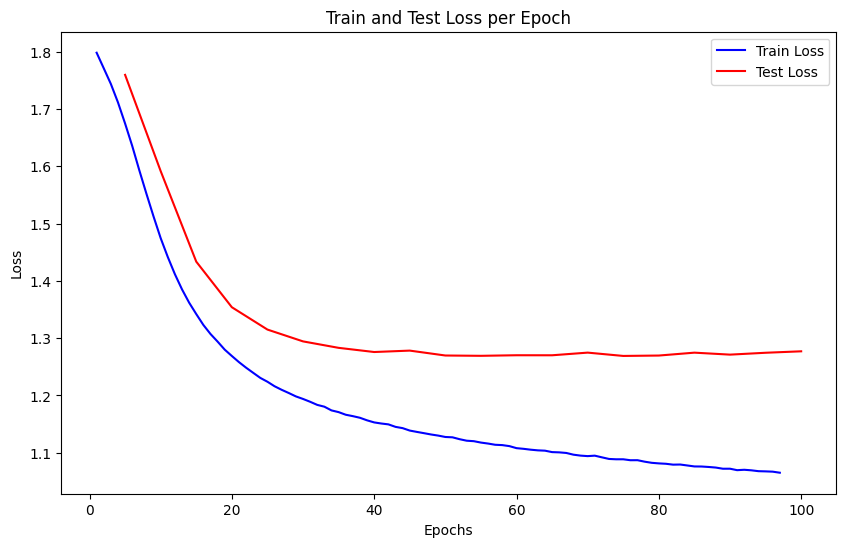

100%|██████████| 313/313 [00:00<00:00, 967.13it/s] 

              precision    recall  f1-score   support

           0       0.38      0.38      0.38      1697
           1       0.34      0.38      0.36      1650
           2       0.33      0.28      0.30      1653
           3       0.34      0.41      0.37      1653
           4       0.33      0.32      0.32      1684
           5       0.33      0.29      0.31      1663

    accuracy                           0.34     10000
   macro avg       0.34      0.34      0.34     10000
weighted avg       0.34      0.34      0.34     10000



In [ ]:
dumbmodel = DumbModel()

trainer = MyTrainer(dumbmodel, device=device)

dic_results["DumbModel"] = trainer.full_proc(train_dataloader=dataloader_train,
                                          valid_dataloader=dataloader_valid, test_dataloader=dataloader_test,
                                          n_epochs=300,
                                          critic_test=5,
                                          lr=1e-4, model_path="DumbModel.pth")

Le premier modèle est simple dans son architecture et converge rapidement mais ne montre pas de résultats très impressionnants. On peut donc utiliser des architectures plus sophistiquées pour voir si on peut augmenter les résultats

## Model 2 convolutionals layers

Le modèle suivant présente deux couches de convolutions mise l'une a la suite de l'autre

In [177]:
class Model2Conv(nn.Module):
    def __init__(self, N=6, C=2, T=2048):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=C, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(8),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4)
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4)
        )
        self.fc = nn.Linear(16*(T//16), N)

        self.out = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return self.out(x)

model2conv = Model2Conv()
print(count_n_param(model2conv))

12798


Epoch 147/300 - Train Loss: 0.5789 - Test Loss: 0.7871:  49%|████▉     | 147/300 [03:17<03:25,  1.35s/it]
/tmp/ipykernel_3594/645861320.py:183: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experim

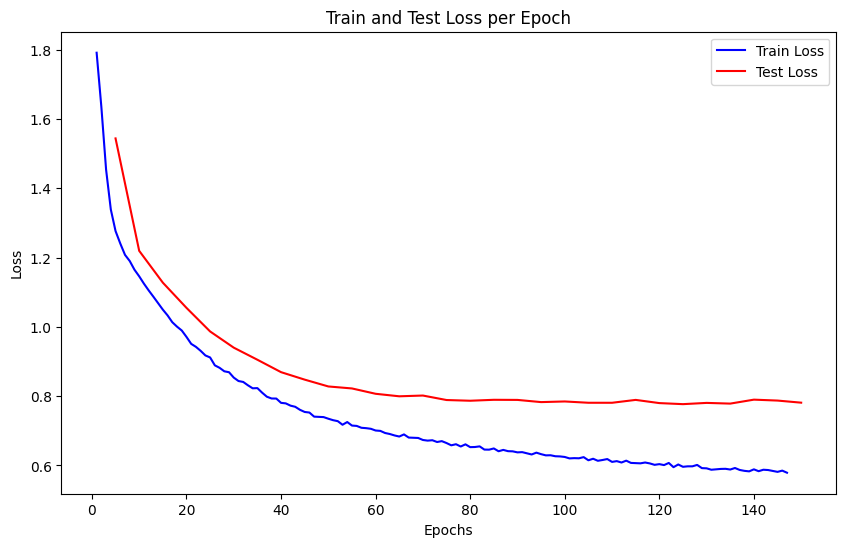

100%|██████████| 313/313 [00:00<00:00, 796.31it/s]


              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1697
           1       0.50      0.55      0.52      1650
           2       0.49      0.43      0.46      1653
           3       0.84      0.82      0.83      1653
           4       0.47      0.44      0.46      1684
           5       0.48      0.50      0.49      1663

    accuracy                           0.60     10000
   macro avg       0.60      0.60      0.60     10000
weighted avg       0.60      0.60      0.60     10000



In [ ]:
trainer = MyTrainer(model2conv, device=device)

dic_results["Model2Conv"] = trainer.full_proc(train_dataloader=dataloader_train,
                                          valid_dataloader=dataloader_valid, test_dataloader=dataloader_test,
                                          n_epochs=300,
                                          critic_test=5,
                                          lr=1e-4, model_path="Model2Conv.pth")

In [39]:
print(f"Accuracy model 2: {dic_results["Model2Conv"]:.4f}")

Accuracy model 2: 0.6039


On obtient de meilleurs résultats simplement en enchainant deux couches de convolutions (on a ainsi augmente le champ receptif du des neuronnes à la fin de l'architecture), il semble donc qu'il soit préférable que le modèle ait un grand champ receptif, par exemple en enchainant les couches de convolutions

## Separable Convolution

In [75]:
class ModelSep(nn.Module):
    def __init__(self, N=6, C=2, T=2048):
        super(ModelSep, self).__init__()

        self.layers = nn.ModuleList()
        in_channels = C
        out_channels = 4

        for i in range(8):
            depthwise_conv = nn.Conv1d(in_channels=in_channels, out_channels=in_channels, 
                                       groups=in_channels, kernel_size=3, 
                                       stride=1, padding='same')
            pointwise_conv = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, 
                                       kernel_size=1, stride=1, padding='same')
            bn = nn.BatchNorm1d(out_channels)
            pool = nn.MaxPool1d(kernel_size=2) # divise la longueur par 2, comme ça a la sortie on peut appliquer
                                               # un linear qui n'aura pas 1000000 de paramètres

            self.layers.append(nn.Sequential(depthwise_conv, pointwise_conv, bn, pool))

            in_channels = out_channels

            out_channels += 2

        conv_output_size = in_channels *8
        self.fc1 = nn.Linear(conv_output_size, N)
        self.dropout = nn.Dropout(0.3) # Dropout permet 
        self.out = nn.LogSoftmax(dim=1)

    def forward(self, x):
        for layer in self.layers:
            x = F.relu(layer(x))

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.out(x)

modelsep = ModelSep()
print(count_n_param(modelsep))

2382


Dans ce modèle, on enchaine 8 couche de "separable" convolution en divisant a chaque fois la longueur de la sortie par 2, on a donc "peu" de paramètres mais 8 couches de convolutions. Les separable convolution permettent de réduire la complexité du modèle en maintenant de bonnes performances

Epoch 500/500 - Train Loss: 0.9035 - Test Loss: 0.5450: 100%|██████████| 500/500 [15:41<00:00,  1.88s/it]
/tmp/ipykernel_3594/645861320.py:183: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experim

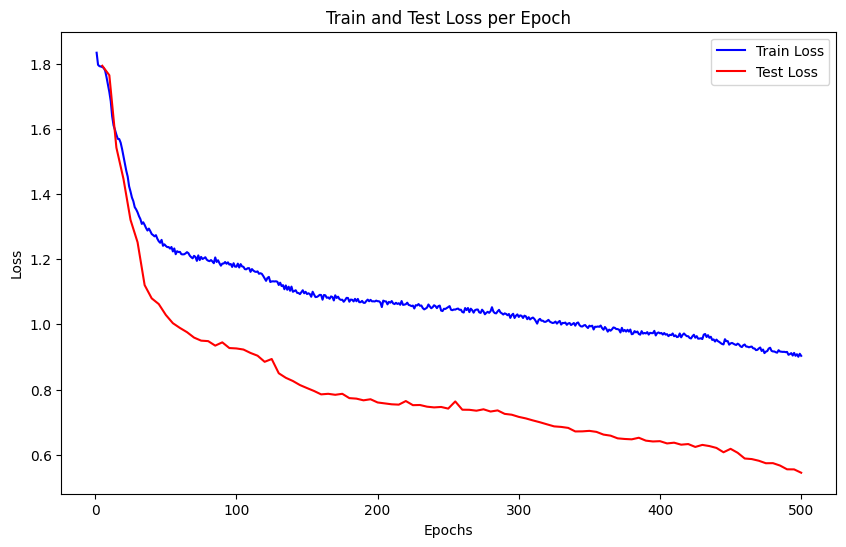

100%|██████████| 313/313 [00:01<00:00, 281.23it/s]


              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1697
           1       0.80      0.80      0.80      1650
           2       0.80      0.76      0.78      1653
           3       0.81      0.88      0.84      1653
           4       0.90      0.72      0.80      1684
           5       0.73      0.81      0.77      1663

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



In [ ]:
trainer = MyTrainer(modelsep, device=device)

dic_results["ModelSep"] = trainer.full_proc(train_dataloader=dataloader_train,
                                          valid_dataloader=dataloader_valid, test_dataloader=dataloader_test,
                                          n_epochs=500,
                                          critic_test=5,
                                          lr=1e-4, model_path="ModelSep.pth")

Le modèle garde une architecture assez "simple": enchainement de separable convolution en utilisant un MaxPool de 2 (après chaque convolution, on divise la longueur de la série par 2). On peut observer un fait assez surprenant que la loss sur le training dataset est supérieure à celle sur le validation dataset. Après vérifications, il ne semble pas y avoir de problèmes particuliers sur le trainer (on utilise a chaque fois le même trainer en changeant **uniquement** le modèle d'entrée (et le nombre d'epochs)) L'accuracy du modèle reste toutefois excellente avec une valeur de 0.80.

In [79]:
_ = trainer._test(dataloader_train)
_ = trainer._test(dataloader_valid)

100%|██████████| 118/118 [00:00<00:00, 146.55it/s]


              precision    recall  f1-score   support

           0       0.84      0.90      0.87      5143
           1       0.83      0.80      0.81      4968
           2       0.80      0.79      0.80      5053
           3       0.79      0.88      0.83      4867
           4       0.93      0.69      0.79      4894
           5       0.74      0.84      0.79      5075

    accuracy                           0.82     30000
   macro avg       0.82      0.82      0.82     30000
weighted avg       0.82      0.82      0.82     30000



100%|██████████| 79/79 [00:00<00:00, 260.53it/s]

              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1653
           1       0.82      0.78      0.80      1745
           2       0.78      0.79      0.78      1590
           3       0.80      0.87      0.83      1639
           4       0.91      0.70      0.79      1660
           5       0.73      0.82      0.77      1713

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.80     10000



Ici bien que le modèle ait de meilleurs performances selon la loss dans le valid que le train, le modèle a cependant des performances similaires (même un peu moins bonnes) sur l'ensemble de validation par rapport à l'ensemble de train.

La loss permet d'entraîner le modèle mais n'est pas forcément la plus pertinente pour mesurer ses performances. Par exemples supposons que le modèle fait une mauvaise classification, si la logprob est très très faible pour la vraie classe de la donnée, alors la loss va augmenter de beaucoup tandis que si on évalue avec l'accuracy (ou precision recall etc...) si le modèle s'est trompé cela impact la métrique mais peu importe la logprob de la vraie classe que le modèle a retourné.

**Paramètre dropout** 

Dans ce modèle on applique un paramètre de dropout de 0.3 qui sert de "régularisation" du modèle, plusieurs avantages du dropout (éviter l'overfitting en faisant en sorte que le modèle ne dépende pas trop de certains paramètres, approximation d'un Bayesian neural network etc...), et le drop out **n'est pas** utilisé pendant le test ce qui peut en partie expliquer les meilleurs performances au test (dans la suite du notebook, on remarquera que tout les modèles qui utilisent un drop out ont ce phénomène)

## Res connexion

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=21):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding="same")
        self.bn1 = nn.BatchNorm1d(out_channels)
        
        self.residual_connection = nn.Conv1d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else None
        
    def forward(self, x):
        identity = x
        x = F.relu(self.bn1(self.conv1(x)), inplace=False)
        
        if self.residual_connection is not None:
            identity = self.residual_connection(identity)
        
        x = x+ identity
        return F.relu(x)

class ModelRes(nn.Module):
    def __init__(self, N=6, C=2, T=2048):
        super(ModelRes, self).__init__()

        self.layers = nn.ModuleList()
        in_channels = C
        out_channels = 8

        for i in range(2):
            self.layers.append(ResidualBlock(in_channels, out_channels))
            in_channels = out_channels
            out_channels +=2

        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)

        self.fc1 = nn.Linear(in_channels, N)
        self.dropout = nn.Dropout(0.3)
        self.out = nn.LogSoftmax(dim=1)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.out(x)


modelres = ModelRes()
print(count_n_param(modelres))


2250


In [24]:
class SeparableConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding="same"):
        super(SeparableConv1d, self).__init__()
        self.depthwise = nn.Conv1d(in_channels, in_channels, kernel_size=kernel_size, groups=in_channels, padding=padding)
        self.pointwise = nn.Conv1d(in_channels, out_channels, kernel_size=1)
        self.bn = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        return F.relu(x)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=21):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding="same")
        self.bn1 = nn.BatchNorm1d(out_channels)
        
        self.residual_connection = nn.Conv1d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else None

    def forward(self, x):
        identity = x
        x = F.relu(self.bn1(self.conv1(x)), inplace=False)
        
        if self.residual_connection is not None:
            identity = self.residual_connection(identity)
        
        x = x + identity
        return F.relu(x)

class ModelRes(nn.Module):
    def __init__(self, N=6, C=2, T=2048):
        super(ModelRes, self).__init__()

        self.layers = nn.ModuleList()
        in_channels = C
        out_channels = 8

        for i in range(2):
            self.layers.append(ResidualBlock(in_channels, out_channels))
            in_channels = out_channels
            out_channels += 1

        self.sep_conv1 = SeparableConv1d(in_channels, in_channels + 1, kernel_size=3)
        self.sep_conv2 = SeparableConv1d(in_channels + 1, in_channels + 2, kernel_size=3)
        in_channels += 2

        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)

        self.fc1 = nn.Linear(in_channels, N)
        self.dropout = nn.Dropout(0.3)
        self.out = nn.LogSoftmax(dim=1)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        x = self.sep_conv1(x)
        x = self.sep_conv2(x)

        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.out(x)

modelres = ModelRes()
print(count_n_param(modelres))


2415


Epoch 172/500 - Train Loss: 1.3001 - Test Loss: 1.1007:  34%|███▍      | 172/500 [14:10<27:01,  4.94s/it]
/tmp/ipykernel_1983/645861320.py:183: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experim

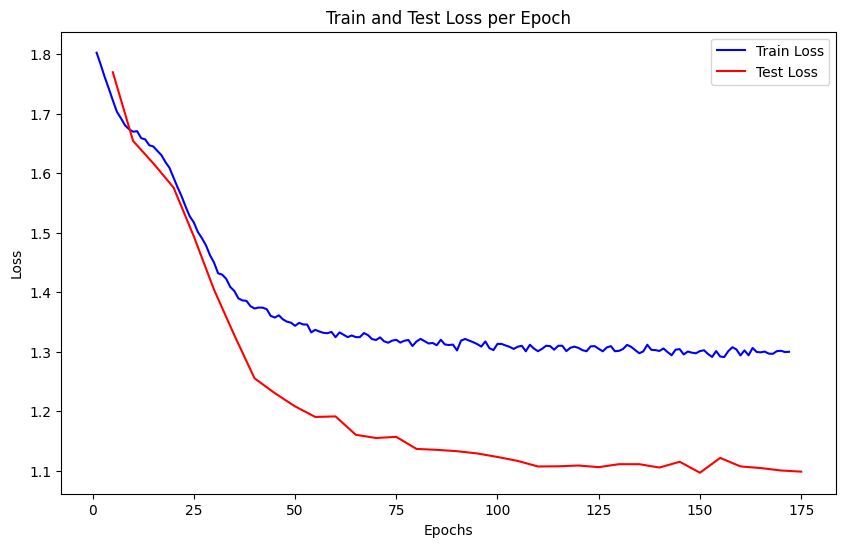

100%|██████████| 313/313 [00:00<00:00, 380.04it/s]

              precision    recall  f1-score   support

           0       0.35      1.00      0.52      1697
           1       0.00      0.00      0.00      1650
           2       0.00      0.00      0.00      1653
           3       0.95      0.80      0.86      1653
           4       0.25      0.04      0.07      1684
           5       0.45      0.94      0.61      1663

    accuracy                           0.46     10000
   macro avg       0.33      0.46      0.34     10000
weighted avg       0.33      0.46      0.34     10000



In [ ]:
trainer = MyTrainer(modelres, device=device)

dic_results["ModelRes"] = trainer.full_proc(train_dataloader=dataloader_train,
                                             valid_dataloader=dataloader_valid, test_dataloader=dataloader_test,
                                             n_epochs=500,
                                             critic_test=5,
                                             lr=1e-4, model_path="ModelRes.pth")

Performances plutôt décevantes, le modèle ne se concentre que sur quelques classes (pour les labels 1 et 2, il n'a fait aucune prédiction!), difficile de comprendre pourquoi ce modèle échoue.

## CNN + Lstm

In [165]:
class CNNLstm(torch.nn.Module):
    def __init__(self, N=6, C=2, T=2048, n_conv=4, out_channels=4, kernel_maxpool=3, bidirectional=False):
        super().__init__()
        multiplier = 2 if bidirectional else 1
        minus = 0 if bidirectional else 6
        self.layers = nn.ModuleList()
        in_channels = C

        for i in range(n_conv):
            depthwise_conv = nn.Conv1d(in_channels=in_channels, out_channels=in_channels, 
                                       groups=in_channels, kernel_size=3, 
                                       stride=1, padding='same')
            pointwise_conv = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, 
                                       kernel_size=1, stride=1, padding='same')
            bn = nn.BatchNorm1d(out_channels)
            pool = nn.MaxPool1d(kernel_size=kernel_maxpool)

            self.layers.append(nn.Sequential(depthwise_conv, pointwise_conv, bn, pool))

            in_channels = out_channels

            out_channels += 2
        self.lstm = torch.nn.LSTM(input_size=out_channels-2, hidden_size=out_channels*2, num_layers=2, batch_first=True, dropout=0.5,
                                  bidirectional=bidirectional)

        self.fc = torch.nn.Linear((out_channels)*2*T//kernel_maxpool**n_conv* multiplier - minus, N)

    def forward(self, x):

        for layer in self.layers:
            x = F.relu(layer(x))
        x = x.permute(0, 2, 1)
        x, _ = self.lstm(x)
        x = x.contiguous().view(x.size(0), -1)
        x = self.fc(x)
        return F.log_softmax(x, dim=-1)

cnnlstm = CNNLstm()
count_n_param(cnnlstm)

12186

Epoch 500/500 - Train Loss: 0.3901 - Test Loss: 0.3796: 100%|██████████| 500/500 [18:15<00:00,  2.19s/it]  
/tmp/ipykernel_1983/645861320.py:183: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exper

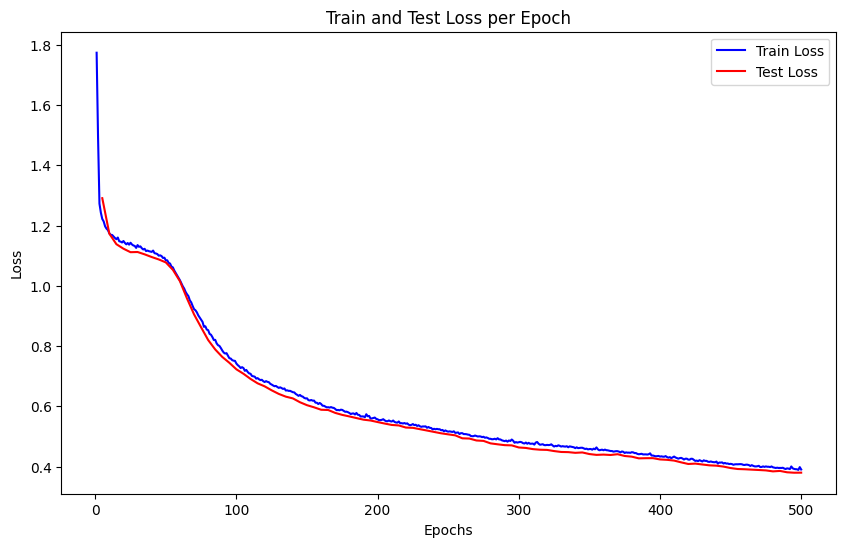

100%|██████████| 313/313 [00:00<00:00, 366.68it/s]

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1697
           1       0.83      0.79      0.81      1650
           2       0.81      0.77      0.79      1653
           3       0.89      0.81      0.85      1653
           4       0.70      0.77      0.74      1684
           5       0.72      0.71      0.71      1663

    accuracy                           0.79     10000
   macro avg       0.80      0.79      0.79     10000
weighted avg       0.80      0.79      0.79     10000



In [ ]:
trainer = MyTrainer(cnnlstm, device=device)


dic_results["CNNLstm"] = trainer.full_proc(train_dataloader=dataloader_train,
                                                 test_dataloader=dataloader_test, valid_dataloader=dataloader_valid,
                                                 n_epochs=500,
                                                 critic_test=5,
                                                 lr=1e-4, model_path="CNNLstm.pth")

Modèle n'a pas encore converger on va l'entraîner encore un peu

Epoch 237/500 - Train Loss: 0.3616 - Test Loss: 0.3601:  47%|████▋     | 237/500 [07:39<08:29,  1.94s/it]
/tmp/ipykernel_1983/645861320.py:183: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experim

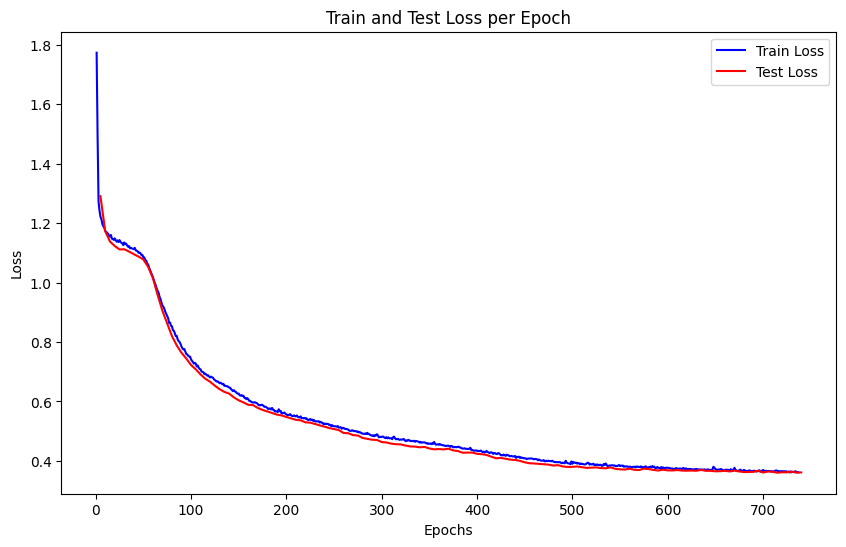

100%|██████████| 313/313 [00:00<00:00, 370.32it/s]

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1697
           1       0.85      0.79      0.82      1650
           2       0.81      0.77      0.79      1653
           3       0.90      0.81      0.85      1653
           4       0.74      0.81      0.78      1684
           5       0.76      0.77      0.76      1663

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



In [167]:
dic_results["CNNLstm"] = trainer.full_proc(train_dataloader=dataloader_train,
                                                 test_dataloader=dataloader_test, valid_dataloader=dataloader_valid,
                                                 n_epochs=500,
                                                 critic_test=5,
                                                 lr=1e-4, model_path="CNNLstm.pth")

**Remarque**
Ici, on ne prends pas l'output du DERNIER layer lstm mais on utilise les output de tout les layers lstm qu'on met dans un FF layer. Généralement (par exemple pour une tâche de forecasting), on prends l'output des derniers layers pour pouvoir utiliser un réseaux lstm sur des données ayant des dimensions qui varient. On a tester le modèle en ne prenant que le dernier output (a la sortie du lstm, on prends x[:,:,-1]) mais les résultats étaient moins bons. Cela peut être dù au fait que pour la tâche de classification, on est intéressé par les informations de toute la série et moins par les informations des dernières données (pour le forecasting par exemple).


Maintenant, on applique le même modèle mais en augmentant le nombre de couches de convolutions et en utilisant des lstm bidirectionnels

Epoch 0/500 - Train Loss: 0.0000 - Test Loss: 0.0000:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 347/500 - Train Loss: 0.3529 - Test Loss: 0.3742:  69%|██████▉   | 347/500 [16:06<07:06,  2.79s/it]
/tmp/ipykernel_1983/645861320.py:183: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experim

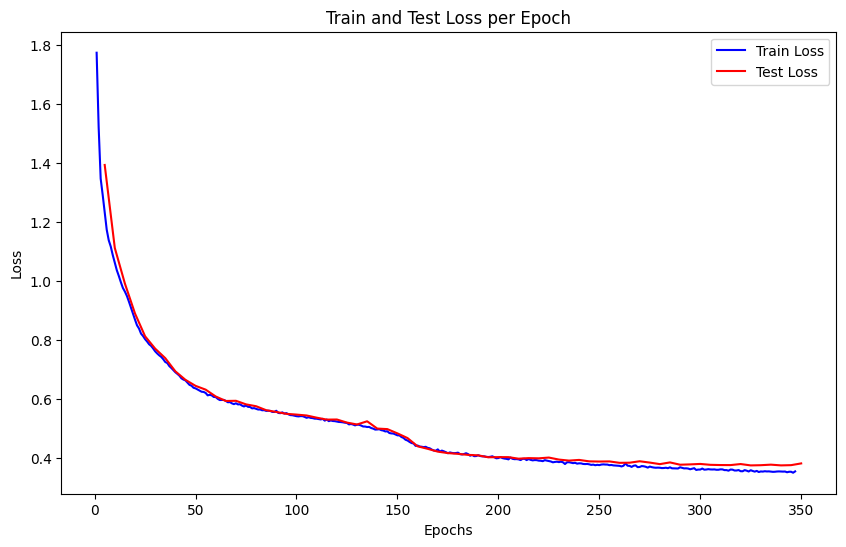

100%|██████████| 313/313 [00:01<00:00, 252.46it/s]

              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1697
           1       0.83      0.81      0.82      1650
           2       0.83      0.79      0.81      1653
           3       0.88      0.81      0.84      1653
           4       0.69      0.83      0.76      1684
           5       0.81      0.72      0.76      1663

    accuracy                           0.81     10000
   macro avg       0.82      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



In [ ]:
cnnlstmbidir = CNNLstm(N=6, C=2, T=2048, n_conv=8, out_channels=6, kernel_maxpool=2, bidirectional=True)
count_n_param(cnnlstmbidir)

trainer = MyTrainer(cnnlstmbidir, device=device)


dic_results["CNNLstm_bidir"] = trainer.full_proc(train_dataloader=dataloader_train,
                                                 test_dataloader=dataloader_test, valid_dataloader=dataloader_valid,
                                                 n_epochs=500,
                                                 critic_test=5,
                                                 lr=1e-4, model_path="CNNLstm_bidir.pth")

## Model LiTE

Cet été, j'ai eu a implémenter le modèle [LiTE](https://germain-forestier.info/publis/dsaa2023.pdf) dont le code en tensorflow est disponible ici [github](https://github.com/MSD-IRIMAS/LITE). Le modèle est un modèle de classification pour les séries temporelles dont les performances sont proches des performances de gros modèles en utilisant de nombreuses méthodes de boosting (par exemple le mécanisme separable conv vu en cours). Le modèle est conçu pour des séries unidimensionnelles, mais on peut l'adapter pour notre cas (2 canaux). Lorsque je l'avais implémenter, le modèle a montré des performances moyennes sur les jeux de données avec des longues séries. 

Le modèle ici est implémenté comme décris dans l'article (même paramètres exceptés pour la taille de kernel que j'ai légèrement augmenté) et en torch. Le modèle est long à entraîner (1h environ avec un gpu alors que les autres modèles n'ont pas pris plus de 20 minutes à être entraîné).

In [170]:
class HybirdLayer(nn.Module):
    """Layers pré-défini qu'on n'entraîne pas, les auteurs de l'articles justifient ça par le fait que le modèle
    ne "perd" pas alors son temps à apprendre des patterns simples mais se concentre sur les plus compliqués
    (par pattern, j'entends les parametres de la convolution qui permettent d'extraire des features, par ex si
    tout les parametres sont a 1, la feature extraite est la somme de tout les élements de la fenêtre)
    """
    def __init__(self, input_channels, kernel_sizes=[2, 4, 8, 16, 32, 64], device="cpu"):
        super(HybirdLayer, self).__init__()
        self.input_channels = input_channels
        self.kernel_sizes = kernel_sizes
        self.conv_layers = nn.ModuleList()

        for kernel_size in kernel_sizes:
            filter_ = np.ones((kernel_size, input_channels, 1))
            indices_ = np.arange(kernel_size)
            filter_[indices_ % 2 == 0] *= -1
            filter_ = torch.tensor(filter_, dtype=torch.float32).permute(2, 1, 0)
            conv_layer = nn.Conv1d(input_channels, 1, kernel_size, padding="same",
                                   bias=False).to(device)
            with torch.no_grad():
                conv_layer.weight.copy_(filter_)
            conv_layer.weight.requires_grad = False
            self.conv_layers.append(conv_layer)

        for kernel_size in kernel_sizes:
            filter_ = np.ones((kernel_size, input_channels, 1))
            indices_ = np.arange(kernel_size)
            filter_[indices_ % 2 > 0] *= -1
            filter_ = torch.tensor(filter_, dtype=torch.float32).permute(2, 1, 0)
            conv_layer = nn.Conv1d(input_channels, 1, kernel_size, padding="same",
                                   bias=False).to(device)
            with torch.no_grad():
                conv_layer.weight.copy_(filter_)
            conv_layer.weight.requires_grad = False
            self.conv_layers.append(conv_layer)

        for kernel_size in kernel_sizes[1:]:
            filter_ = np.zeros((kernel_size + kernel_size // 2, input_channels, 1))
            xmash = np.linspace(0, 1, kernel_size // 4 + 1)[1:].reshape((-1, 1, 1))
            filter_left = xmash ** 2
            filter_right = filter_left[::-1]
            filter_[0:kernel_size // 4] = -filter_left
            filter_[kernel_size // 4:kernel_size // 2] = -filter_right
            filter_[kernel_size // 2:3 * kernel_size // 4] = 2 * filter_left
            filter_[3 * kernel_size // 4:kernel_size] = 2 * filter_right
            filter_[kernel_size:5 * kernel_size // 4] = -filter_left
            filter_[5 * kernel_size // 4:] = -filter_right
            filter_ = torch.tensor(filter_, dtype=torch.float32).permute(2, 1, 0)
            conv_layer = nn.Conv1d(input_channels, 1, kernel_size + kernel_size // 2,
                                   padding="same", bias=False).to(device)
            with torch.no_grad():
                conv_layer.weight.copy_(filter_)
            conv_layer.weight.requires_grad = False
            self.conv_layers.append(conv_layer)

        self.relu = nn.ReLU().to(device)

    def forward(self, input_tensor):
        conv_list = [conv(input_tensor) for conv in self.conv_layers]
        hybrid_layer = torch.cat(conv_list, dim=1)
        hybrid_layer = self.relu(hybrid_layer)
        return hybrid_layer  # .permute(0,2,1)


class SeparableConv1D(nn.Module):
    """Mécanisme bottleneck dans l'article (depth wise puis point wise comme dans le cours)
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1, device="cpu"):
        super(SeparableConv1D, self).__init__()
        self.depthwise = nn.Conv1d(in_channels, in_channels, kernel_size, stride=stride,
                                   padding="same", dilation=dilation, groups=in_channels,
                                   bias=False).to(device)
        self.pointwise = nn.Conv1d(in_channels, out_channels, 1, stride=1, padding="same",
                                   dilation=1, groups=1, bias=False).to(device)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x


class FCNModule(nn.Module):
    def __init__(self, input_channels,  n_filters, kernel_size, dilation_rate=1, stride=1,
                 activation="relu", device="cpu"):
        super(FCNModule, self).__init__()
        self.separable_conv = SeparableConv1D(input_channels, n_filters, kernel_size,
                                              stride=stride, dilation=dilation_rate,
                                              device=device).to(device)
        self.batch_norm = nn.BatchNorm1d(n_filters).to(device)
        self.activation = nn.ReLU().to(device) if activation == "relu" else nn.Identity()

    def forward(self, input_tensor):
        x = self.separable_conv(input_tensor)
        x = self.batch_norm(x)
        x = self.activation(x)

        return x


class InceptionModule(nn.Module):
    """Succession de neuronnes convolutionnels en modifiant la taille du kernel (on diminue au fur et a mesure),
    le dilatation rate permet de "skip" des données lorsque l'on applique le produit de convolution
    en pratique cela permet d'augmenter le champ receptif (autrement qu'en stackant des neuronnes de convolutions)
    """
    def __init__(self, input_channels, n_filters, dilation_rate, stride=1, kernel_size=41,
                 activation="linear", use_hybird_layer=False, use_multiplexing=True, device="cpu"):
        super(InceptionModule, self).__init__()
        self.n_filters = n_filters
        self.dilation_rate = dilation_rate
        self.stride = stride
        self.kernel_size = kernel_size
        self.activation = activation
        self.use_hybird_layer = use_hybird_layer
        self.use_multiplexing = use_multiplexing
        self.device = device

        if not self.use_multiplexing:
            self.n_convs = 1
            self.n_filters *= 3
        else:
            self.n_convs = 3

        self.kernel_size_s = [self.kernel_size // (2 ** i) for i in range(self.n_convs)]
        self.conv_list = nn.ModuleList()

        for i in range(len(self.kernel_size_s)):
            conv = nn.Conv1d(input_channels, self.n_filters, self.kernel_size_s[i],
                             stride=self.stride, padding="same", dilation=self.dilation_rate,
                             bias=False).to(device)
            self.conv_list.append(conv)

        if self.use_hybird_layer:
            n = self.n_filters * self.n_convs + 17
        else:
            n = self.n_filters * self.n_convs
        self.batch_norm = nn.BatchNorm1d(n).to(device)
        self.relu = nn.ReLU().to(device)
        self.final_pool = torch.nn.MaxPool1d(kernel_size=2)

    def forward(self, input_tensor):

        conv_outputs = [conv(input_tensor).squeeze(2) for conv in self.conv_list]

        if self.use_hybird_layer:
            self.hybird = HybirdLayer(input_channels=input_tensor.shape[1],
                                      device=self.device).to(self.device)
            hybird_output = self.hybird(input_tensor)
            conv_outputs.append(hybird_output)
        if len(conv_outputs) > 1:
            concatenated = torch.cat(conv_outputs, dim=1)
        else:
            concatenated = conv_outputs[0]

        #x = self.batch_norm(concatenated)
        x = self.batch_norm(concatenated)
        x = self.final_pool(x)
        x = self.relu(x)

        return x


class LITE(nn.Module):
    def __init__(self, n_classes, n_filters, kernel_size=41, use_custom_filters=True,
                 use_dilation=True, output_directory="", dilatation_rate=1, device="cpu",
                 n_channels=2):
        super(LITE, self).__init__()

        self.n_classes = n_classes
        self.n_filters = n_filters
        self.kernel_size = kernel_size
        self.use_custom_filters = use_custom_filters
        self.use_dilation = use_dilation
        self.output_directory = output_directory
        self.dilatation_rate = dilatation_rate
        self.n_channels = n_channels

        self.inception = InceptionModule(input_channels=2, n_filters=self.n_filters,
                                         dilation_rate=1, use_hybird_layer=self.use_custom_filters,
                                         device=device)
        self.inception.to(device)

        self.fcn_modules = nn.ModuleList()
        if self.use_custom_filters:
            input_channels = n_filters * 3 + 17
        else:
            input_channels = n_filters * 3
        i = 0
        dilation_rate = 2 ** (i + 1) if self.use_dilation else 1
        fcn_module1 = FCNModule(input_channels=input_channels, n_filters=self.n_filters,
                                kernel_size=self.kernel_size // (2**i),
                                dilation_rate=dilation_rate, stride=1,
                                activation="relu", device=device)
        fcn_module1.to(device)
        self.fcn_modules.append(fcn_module1)
        i = 1
        dilation_rate = 2 ** (i + 1) if self.use_dilation else 1
        fcn_module2 = FCNModule(input_channels=n_filters, n_filters=self.n_filters,
                                kernel_size=self.kernel_size // (2**i),
                                dilation_rate=dilation_rate, stride=1,
                                activation="relu", device=device)
        fcn_module2.to(device)

        self.fcn_modules.append(fcn_module2)
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1).to(device)

        self.output_layer = nn.Linear(self.n_filters, self.n_classes).to(device)
        self.softmax = nn.Softmax(dim=1).to(device)

    def forward(self, x):

        x = x.view(-1,  self.n_channels, x.shape[-1]) 
        x = self.inception(x)
        for fcn_module in self.fcn_modules:
            x = fcn_module(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.output_layer(x)
        x = self.softmax(x)
        return x


In [ ]:
model_lite = LITE(6, 32, kernel_size=21, use_custom_filters=True, device=device)
model_lite.load_state_dict(torch.load("model_lite.pth"), strict=False)
# Message warning du au fait que le modèle a des poids fixes
# J'avais deja entraîné le modèle dans un autre notebook mais j'ai perdu la cellule (supprimée sans faire exprès),
# On load donc simplement le modèle, l'entraînement a pris environ une heure (avec gpu)

/tmp/ipykernel_1983/2745717994.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_lite.load_state_dict(torch.load("model_lite.pth"), strict=False)


_IncompatibleKeys(missing_keys=[], unexpected_keys=['inception.hybird.conv_layers.0.weight', 'inception.hybird.conv_layers.1.weight', 'inception.hybird.conv_layers.2.weight', 'inception.hybird.conv_layers.3.weight', 'inception.hybird.conv_layers.4.weight', 'inception.hybird.conv_layers.5.weight', 'inception.hybird.conv_layers.6.weight', 'inception.hybird.conv_layers.7.weight', 'inception.hybird.conv_layers.8.weight', 'inception.hybird.conv_layers.9.weight', 'inception.hybird.conv_layers.10.weight', 'inception.hybird.conv_layers.11.weight', 'inception.hybird.conv_layers.12.weight', 'inception.hybird.conv_layers.13.weight', 'inception.hybird.conv_layers.14.weight', 'inception.hybird.conv_layers.15.weight', 'inception.hybird.conv_layers.16.weight'])

In [ ]:
trainer = MyTrainer(model_lite, device=device)

labels, preds = trainer._test(dataloader_test)

  0%|          | 0/313 [00:00<?, ?it/s]/home/onyxia/work/.venv/lib/python3.12/site-packages/torch/nn/modules/conv.py:370: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv1d(
100%|██████████| 313/313 [00:21<00:00, 14.79it/s]


              precision    recall  f1-score   support

           0       0.84      0.96      0.89      1697
           1       0.83      0.76      0.79      1650
           2       0.80      0.76      0.78      1653
           3       0.83      0.90      0.86      1653
           4       0.83      0.83      0.83      1684
           5       0.86      0.79      0.82      1663

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



Le modèle a de très bonnes performances mais pour un temps d'entraînement beaucoup plus long. De plus, le modèle fonctionne effectivement sur des données multivariées (contrairement à l'article qui ne parle que de données univariées), selon le cas d'application il peut être intéressant d'implémenter ce modèle.

##  Synthese de résultats


Une fois que votre ou vos réseaux sont entrainez vous comparez leurs performances selon les métriques définies en introduction sur l'ensemble de test sans oublier de mesurer également la complexité de chaque approche en termes de nombre de paramètres. Si vous avez testé des approches qui vous semblent avoir échoué vous pouvez rédiger un petit paragraphe pour expliquer votre analyse de cet échec.

In [ ]:
# Encore une fois, on crée une classe pour gérer ça plus efficacement

In [175]:
class EvalModels(object):
    def __init__(self, list_models, device="cuda"):
        self.list_models = list_models #{"model_1": model_1, "model_2": model_2, ...} ou les items sont les classes des modèles
    # avec la liste de modèles, on parcours la liste, on load le trainer on charge le modèle et ensuite on peut les évaluer
    # et stockers leurs resultats dans une liste
        self.list_scores = {}
        self.device = device

    def eval_all_models(self, dataloader, verbose=False):
        for model_name in tqdm(self.list_models.keys()) if verbose else self.list_models.keys():
            model = self.list_models[model_name].to(self.device)
            trainer = MyTrainer(model, device=self.device)

            labels, preds = trainer._test(dataloader, by_snr=True)
            self.list_scores[model_name] = (labels, preds)
    
    def _show_confusion(self, snr, model_name):
        lab, pred = self.list_scores[model_name]
        plot_cm(confusion_matrix(lab[f'{snr}'], pred[f'{snr}']), snr, model_name)


    def acc_snr(self, model_name):
        labels_dict, preds_dict = self.list_scores[model_name]

        snr_values = []
        accuracies = []
        for snr in labels_dict.keys():
            labels = labels_dict[snr]
            preds = preds_dict[snr]
            accuracy = np.mean(np.array(labels) == np.array(preds))
            snr_values.append(int(snr))
            accuracies.append(accuracy)

        plt.figure(figsize=(12,3))
        plt.plot(snr_values, accuracies, marker='o')
        plt.title(f"Acc vs Snr, Model {model_name}")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.xticks(snr_values)
        plt.yticks([0,1])
        plt.show()

    def show_results(self, model_name="model cnn"):
        for snr in [0, 10, 20, 30]:
            self._show_confusion(snr, model_name)


def plot_cm(cm, snr=0, model_name="cnn"):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
    plt.title(f"Matrice de snr {snr} pour le modèle {model_name}")
    plt.show()


In [ ]:
# Si les modèles ne sont pas encore entraîner, faire tourner ce code :

dumbmodel = DumbModel()
dumbmodel.load_state_dict(torch.load("DumbModel.pth"), strict=False)

model2conv = Model2Conv()
model2conv.load_state_dict(torch.load("Model2Conv.pth"), strict=False)

modelsep = ModelSep()
modelsep.load_state_dict(torch.load("ModelSep.pth"), strict=False)

modelres = ModelRes()
modelres.load_state_dict(torch.load("ModelRes.pth"), strict=False)

cnnlstm = CNNLstm()
cnnlstm.load_state_dict(torch.load("CNNLstm.pth"), strict=False)

cnnlstmbidir = CNNLstm(N=6, C=2, T=2048, n_conv=8, out_channels=6, kernel_maxpool=2, bidirectional=True)
cnnlstmbidir.load_state_dict(torch.load("CNNLstm_bidir.pth"), strict=False)

model_lite = LITE(6, 32, kernel_size=21, use_custom_filters=True, device=device)
model_lite.load_state_dict(torch.load("model_lite.pth"), strict=False)

# On aurai pu optimiser avec une boucle et un dictionnaire en utilisant global() mais 
# Le fait que certains modèles ont des paramètres spécifiques (lite et lstmbidir) rendent la boucle
# plus compliquée a mettre en place

/tmp/ipykernel_1983/3971500515.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dumbmodel.load_state_dict(torch.load("DumbModel.pth"), strict=False)
/tmp/ipykernel_1983/3

_IncompatibleKeys(missing_keys=[], unexpected_keys=['inception.hybird.conv_layers.0.weight', 'inception.hybird.conv_layers.1.weight', 'inception.hybird.conv_layers.2.weight', 'inception.hybird.conv_layers.3.weight', 'inception.hybird.conv_layers.4.weight', 'inception.hybird.conv_layers.5.weight', 'inception.hybird.conv_layers.6.weight', 'inception.hybird.conv_layers.7.weight', 'inception.hybird.conv_layers.8.weight', 'inception.hybird.conv_layers.9.weight', 'inception.hybird.conv_layers.10.weight', 'inception.hybird.conv_layers.11.weight', 'inception.hybird.conv_layers.12.weight', 'inception.hybird.conv_layers.13.weight', 'inception.hybird.conv_layers.14.weight', 'inception.hybird.conv_layers.15.weight', 'inception.hybird.conv_layers.16.weight'])

In [181]:
all_models = {"DumbModel":dumbmodel,
              "2 Convolutions": model2conv,
              "Separable convolutions": modelsep,
              "pseudo resnet": modelres,
              "cnn lstm": cnnlstm,
              "cnn lstm bidir": cnnlstmbidir,
              "LiTE": model_lite
              }

In [182]:
evaluator = EvalModels(all_models)
evaluator.eval_all_models(dataloader_test, verbose=True)

100%|██████████| 7/7 [00:13<00:00,  1.88s/it]


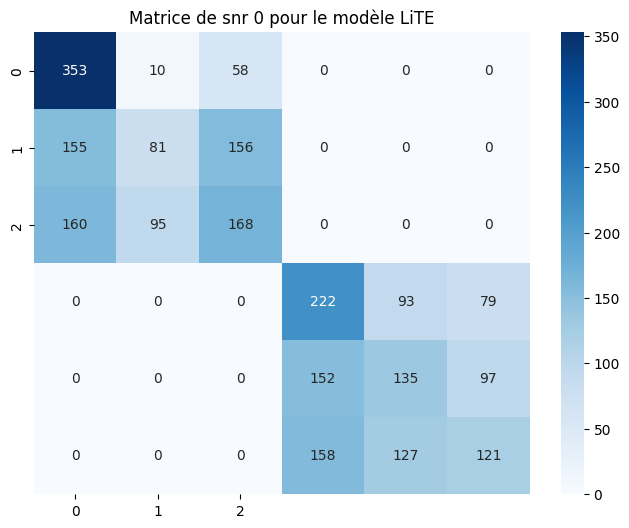

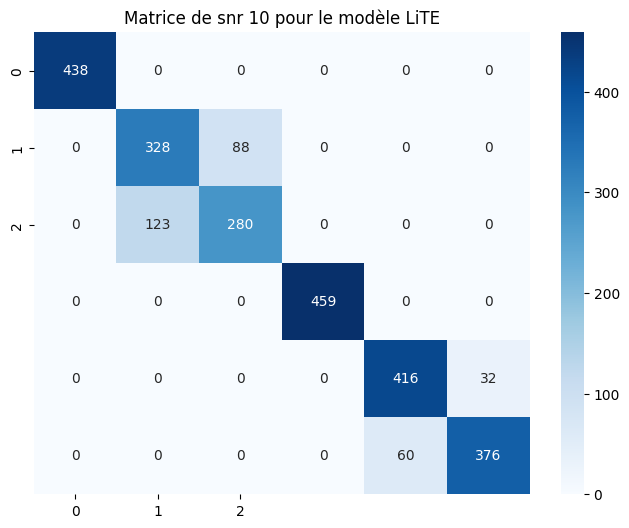

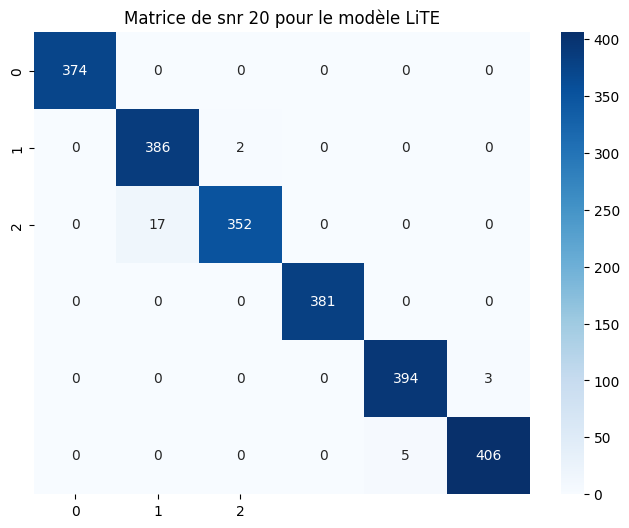

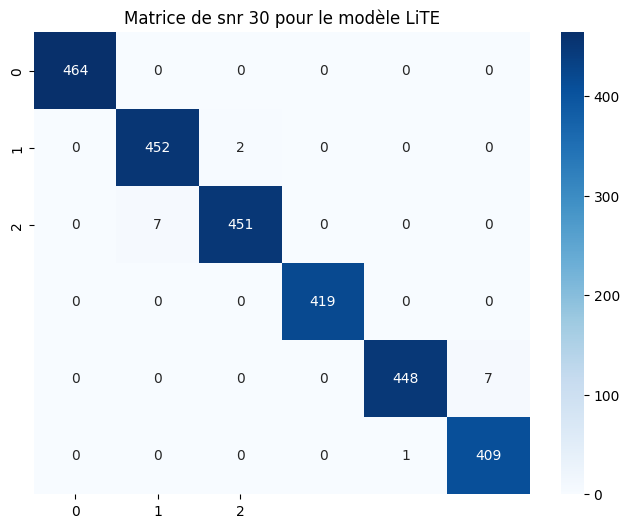

In [184]:
evaluator._show_confusion(0, "LiTE")
evaluator._show_confusion(10, "LiTE")
evaluator._show_confusion(20, "LiTE")
evaluator._show_confusion(30, "LiTE")

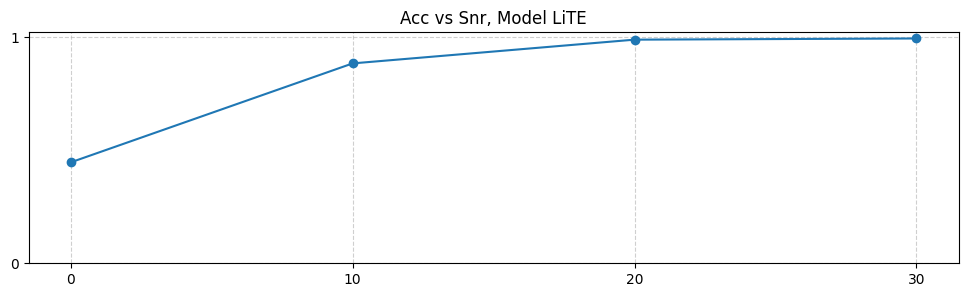

In [185]:
evaluator.acc_snr("LiTE")

Ici, on voit que les modèles ne parviennent pas a depasser $\approx 85\%$ d'accuracy. En regardant la matrice de confusion des résultats, on voit que cela est en grande partie du aux "SNR 0", qui correspond à des signaux dont le bruit et le signal ont la même puissance, les modèles arrivent donc "mal" a distinguer les classes. on voit que si on résumait le problème a une classification binaire (label 1,2,3 -> classe 0, label 4,5,6 -> classe 1), on aurait 100% d'accuracy pour le modèle LITE sur l'ensemble de test, on voit donc ici que le bruit est surement trop élevé (par rapport au signal) ce qui rends trop difficile pour le modèle de discriminer les signaux.

On a utiliser différends modèles, on a vu par exemple que enchaîner les couches de convolutions (et donc augmenter le champ receptif) semblait avoir un impact positif sur le modèle (on peut donc penser que pour bien discriminer les signaux, le modèle doit pouvoir modéliser des interactions entre les points éloignés de la série). Les architectures plus complexes montrent de meilleurs résultats (mais au prix d'avoir un modèle plus coûteux à entraîner). 

Le dernier modèle (LiTE) est plutot efficace (on ne s'y attendait pas car quand je l'avais implémenter, il performait mal sur des données composés de segments "longs") mais propose une architecture qui semble plutot efficace en général pour la tâche de classification en utilisant des méthodes pour réduire la complexité du modèle (le modèle LiTE est designé pour montrer de performances similaires aux gros modèles tel que [Inception](https://arxiv.org/abs/1409.4842)) mais dans notre cas, des résultats très proches peuvent être obtenus avec une architecture encore plus simple.